# Table of contents

* [1. Datasets import](#import)
* [2.Data Exploration](#exploration)
  * [2.1. Health](#health)
  * [2.2. Habits](#habits)
  * [2.3. Demo](#demo)
* [3. Preprocessing steps](#preprocessing)
  * [3.1. Outliers](#outliers)
  * [3.2. Types conversion](#types)
  * [3.3. Encoding of ordinal features](#ordinal)
  * [3.4. Feature Engineering](#feature_eng)
  * [3.5. Scaling](#scaling)
  * [3.6. Missing Values](#missing)
  * [3.7. Feature selection](#fselection)
    * [3.7.1. Filter methods](#filter)
        * [3.7.1.1 Univariate variables](#univariate)
        * [3.7.1.2. Chi-squared for categorical variables](#chi2)
        * [3.7.1.3. Mutual information](#mutual_info)
        * [3.7.1.4. Spearman Correlation](#spearman)
    * [3.7.2. Wrapper methods - RFE](#rfe)
    * [3.7.3. Embedded methods - Lasso](#lasso)
  * [3.8. Transforming categorical variables](#categorical)
* [4. Model Selection and Evaluation](#model_selection)
* [5. Final data preprocessing](#final_preprocessing)
* [6. Models Fine Tuning](#finetuning)
  * [6.1. Random Forest](#randomforest)
  * [6.2. Gradient Boosting](#gradientboosting)
  * [6.3. MLP](#mlp)
* [7. Assessment and Finel Model Choice](#assessment)
  * [7.1. F1-Score with CV](#f1_score)
  * [7.2. Decision boundaries](#decisionboundaries)
  * [7.3. ROC and AUC](#roc)
  * [7.4. Confusion Matrix](#confusionmatrix)
* [8. Predictions for the test data](#testpredictions)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from math import ceil
from scipy import stats as st
from scipy.stats import uniform
import random

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE, SelectKBest, chi2, mutual_info_classif
from sklearn.svm import LinearSVC

# Data Splitting
from sklearn.model_selection import train_test_split, StratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Fine Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Evaluation
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

np.random.seed(20)
random.seed(20)


# Datasets import <a class="anchor" id="import"></a>

In [ ]:
data_health = pd.read_excel("/content/drive/MyDrive/Machine Learning/train_health.xlsx")
data_habits = pd.read_excel('/content/drive/MyDrive/Machine Learning/train_habits.xlsx')
data_demo = pd.read_excel("/content/drive/MyDrive/Machine Learning/train_demo.xlsx")

data_health.set_index('PatientID', inplace = True)
data_habits.set_index('PatientID', inplace = True)
data_demo.set_index('PatientID', inplace = True)

y = data_demo['Disease']

In [ ]:
data_health_test = pd.read_excel("/content/drive/MyDrive/Machine Learning/test_health.xlsx")
data_habits_test = pd.read_excel('/content/drive/MyDrive/Machine Learning/test_habits.xlsx')
data_demo_test = pd.read_excel("/content/drive/MyDrive/Machine Learning/test_demo.xlsx")

data_health_test.set_index('PatientID', inplace = True)
data_habits_test.set_index('PatientID', inplace = True)
data_demo_test.set_index('PatientID', inplace = True)

data_test = pd.concat([data_health_test, data_habits_test, data_demo_test], axis = 1, join = 'inner')

# Data Exploration <a class="anchor" id="exploration"></a>

### **Health** <a class="anchor" id="health"></a>

#### General overview

In [ ]:
data_health.head()

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
PatientID,,,,,,,,
1167,155,67,358,120,21,2,More than 3 years,Neither I nor my immediate family have diabetes.
1805,173,88,230,142,9,0,Not sure,Neither I nor my immediate family have diabetes.
1557,162,68,226,122,26,0,More than 3 years,Neither I nor my immediate family have diabetes.
1658,180,66,313,125,13,8,Not sure,I have/had pregnancy diabetes or borderline di...
1544,180,58,277,125,18,2,More than 3 years,I have/had pregnancy diabetes or borderline di...


In [ ]:
data_health.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1167 to 1117
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Height            800 non-null    int64 
 1   Weight            800 non-null    int64 
 2   High_Cholesterol  800 non-null    int64 
 3   Blood_Pressure    800 non-null    int64 
 4   Mental_Health     800 non-null    int64 
 5   Physical_Health   800 non-null    int64 
 6   Checkup           800 non-null    object
 7   Diabetes          800 non-null    object
dtypes: int64(6), object(2)
memory usage: 56.2+ KB


In [ ]:
data_health.describe(include = 'all')

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800,800
unique,NaN,NaN,NaN,NaN,NaN,NaN,4,4
top,NaN,NaN,NaN,NaN,NaN,NaN,More than 3 years,Neither I nor my immediate family have diabetes.
freq,NaN,NaN,NaN,NaN,NaN,NaN,429,392
mean,167.806250,67.82750,249.322500,131.053750,17.345000,4.558750,NaN,NaN
std,7.976888,12.11347,51.566631,17.052693,5.385139,5.449189,NaN,NaN
min,151.000000,40.00000,130.000000,94.000000,0.000000,0.000000,NaN,NaN
25%,162.000000,58.00000,213.750000,120.000000,13.000000,0.000000,NaN,NaN
50%,167.000000,68.00000,244.000000,130.000000,18.000000,3.000000,NaN,NaN
75%,173.000000,77.00000,280.000000,140.000000,21.000000,7.000000,NaN,NaN


There are no inconsistencies found in the data

In [ ]:
print('There are',data_health.duplicated().sum(), 'duplicates in the health dataset')

There are 4 duplicates in the health dataset


#### Visualizations

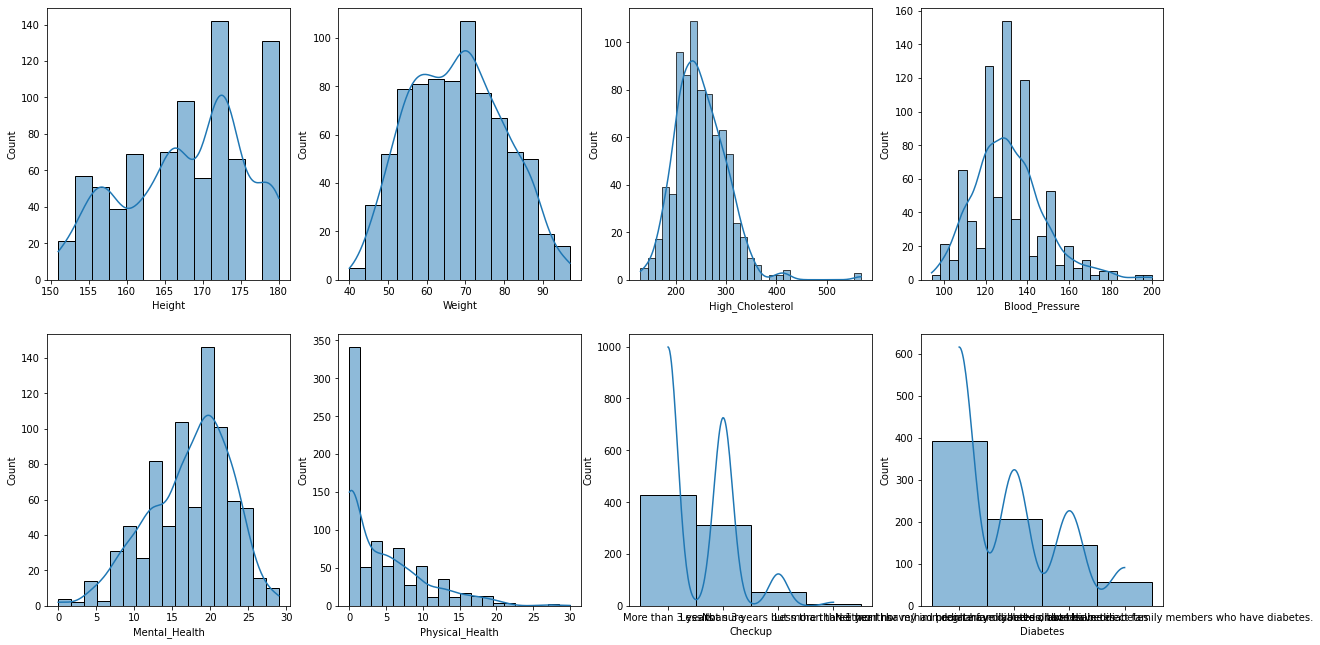

In [ ]:
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(data_health.columns) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), data_health.columns): # Notice the zip() function and flatten() method
    # ax.hist(data_health[feat])
    sns.histplot(data = data_health, x = data_health[feat], kde = True, ax = ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

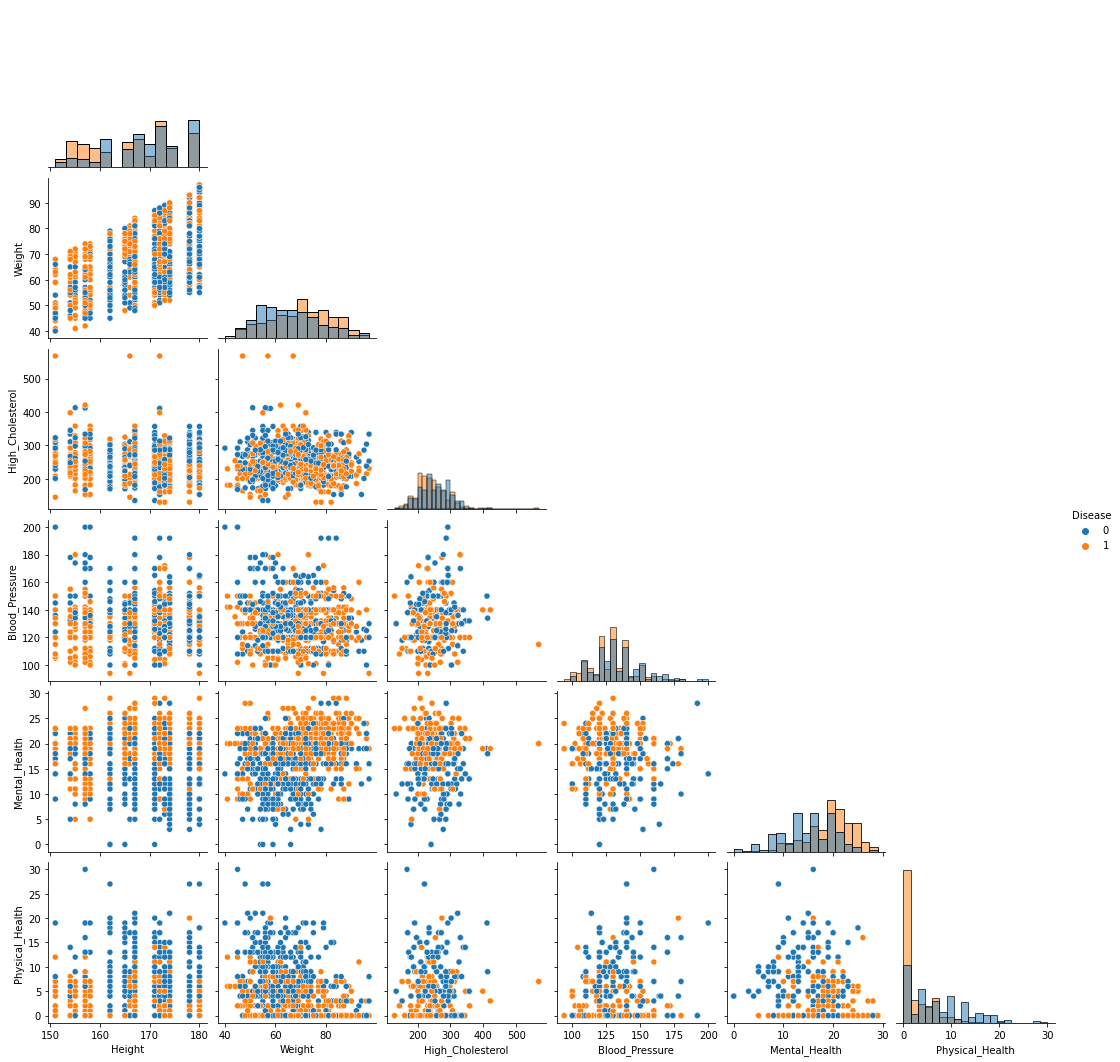

In [ ]:
data_health_with_target = data_health.copy()
data_health_with_target['Disease'] = y

pairplot = sns.pairplot(data_health_with_target, diag_kind="hist", hue = 'Disease', corner = True)
pairplot.savefig("/content/drive/MyDrive/Machine Learning/pairplot.png") 

There is no variable that well discriminates the target variable alone, not even paired with some other variable. Mental_Health and Physical_Health combined with other variables show a kind of pattern, so they will probably be considered important during feature selection.

#### Check outliers

Text(0.5, 0.98, "Health Variables' Box Plots")

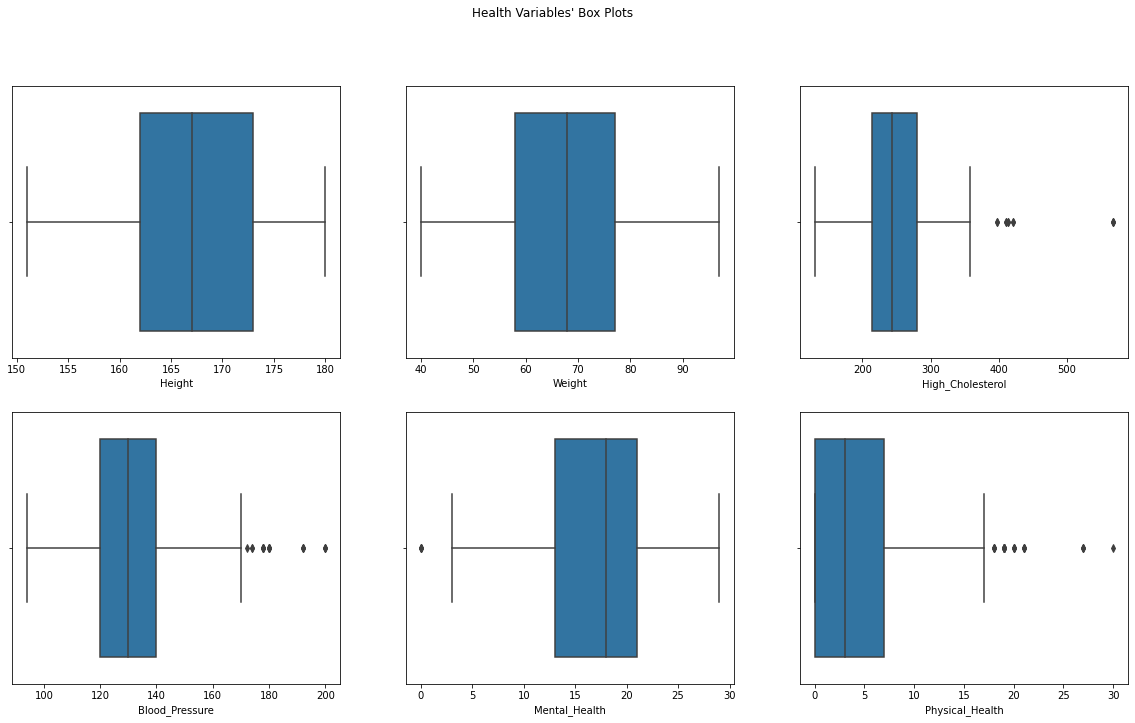

In [ ]:
data_health_num = data_health.select_dtypes(include=np.number).set_index(data_health.index)

fig, axes = plt.subplots(2, ceil(len(data_health_num.columns) / 2), figsize=(20, 11))

for ax, feat in zip(axes.flatten(), data_health_num.columns):
    sns.boxplot(x=data_health_num[feat], ax=ax)
    
plt.suptitle("Health Variables' Box Plots")

Analysis of the target variable on the possible outliers

In [ ]:
data_health_with_target[data_health['High_Cholesterol'] > 375]['Disease'].value_counts()

1    7
0    4
Name: Disease, dtype: int64

In [ ]:
data_health_with_target[data_health['Blood_Pressure'] > 170]['Disease'].value_counts()

0    15
1     4
Name: Disease, dtype: int64

In [ ]:
data_health_with_target[data_health['Mental_Health'] < 5]['Disease'].value_counts()

0    9
Name: Disease, dtype: int64

In [ ]:
data_health_with_target[data_health['Physical_Health'] > 17]['Disease'].value_counts()

0    24
1     1
Name: Disease, dtype: int64

In [ ]:
data_health_with_target[data_health['Physical_Health'] > 17]

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes,Disease
PatientID,,,,,,,,,
1175,157,45,292,200,14,19,Not sure,Neither I nor my immediate family have diabetes.,0
1481,157,57,411,150,19,19,Not sure,Neither I nor my immediate family have diabetes.,0
1661,174,52,322,114,15,21,Less than 3 years but more than 1 year,Neither I nor my immediate family have diabetes.,0
1685,172,58,411,150,19,19,Not sure,Neither I nor my immediate family have diabetes.,0
1258,180,69,235,120,25,18,Not sure,"I don't have diabetes, but I have direct famil...",0
1180,162,71,191,140,16,19,Not sure,Neither I nor my immediate family have diabetes.,0
1787,167,58,302,140,11,20,Not sure,Neither I nor my immediate family have diabetes.,0
1528,178,58,274,178,16,20,Not sure,"I don't have diabetes, but I have direct famil...",1
1933,180,79,235,120,25,18,Not sure,"I don't have diabetes, but I have direct famil...",0


The majority of people that answered with a value of Physical_Health greater than 17 are not ill with the Smith Parasite.

### **Habits** <a class="anchor" id="habits"></a>

#### General overview

In [ ]:
data_habits.head()

,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit
PatientID,,,,,
1167,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters
1805,No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters
1557,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter
1658,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter
1544,No,I consider myself a social drinker,No,1 to 2 pieces of fruit in average,More than half a liter but less than one liter


In [ ]:
data_habits.shape

(800, 5)

In [ ]:
data_habits.describe(include="all").T

,count,unique,top,freq
Smoking_Habit,800,2,No,673
Drinking_Habit,800,3,I usually consume alcohol every day,406
Exercise,800,2,No,536
Fruit_Habit,800,5,Less than 1. I do not consume fruits every day.,452
Water_Habit,800,3,Between one liter and two liters,364


In [ ]:
data_habits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1167 to 1117
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Smoking_Habit   800 non-null    object
 1   Drinking_Habit  800 non-null    object
 2   Exercise        800 non-null    object
 3   Fruit_Habit     800 non-null    object
 4   Water_Habit     800 non-null    object
dtypes: object(5)
memory usage: 37.5+ KB


In [ ]:
data_habits.isna().sum()

Smoking_Habit     0
Drinking_Habit    0
Exercise          0
Fruit_Habit       0
Water_Habit       0
dtype: int64

In [ ]:
print('There are',data_habits.duplicated().sum(), 'duplicates in the habits dataset')

There are 707 duplicates in the habits dataset


#### Visualizations

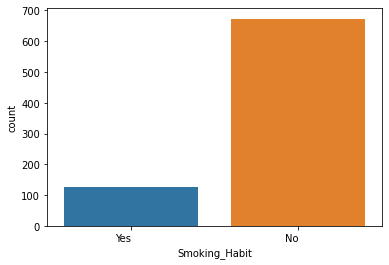

In [ ]:
smoking=sns.countplot(x=data_habits["Smoking_Habit"], order=['Yes','No'])
smoking.set_xticklabels(smoking.get_xticklabels(), ha="right")

plt.show()

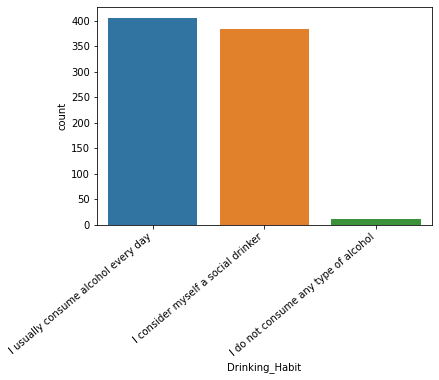

In [ ]:
drinking=sns.countplot(x=data_habits["Drinking_Habit"], order=['I usually consume alcohol every day','I consider myself a social drinker','I do not consume any type of alcohol'])
drinking.set_xticklabels(drinking.get_xticklabels(), rotation=40, ha="right")

plt.show()

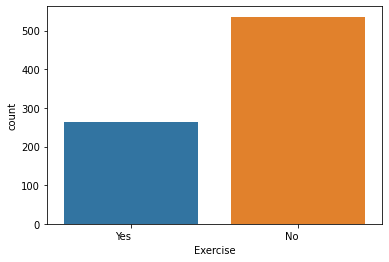

In [ ]:
exercise=sns.countplot(x=data_habits["Exercise"], order=['Yes','No'])
exercise.set_xticklabels(exercise.get_xticklabels(), ha="right")

plt.show()

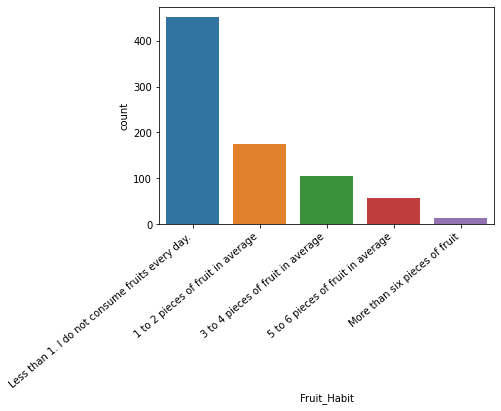

In [ ]:
fruit=sns.countplot(x=data_habits["Fruit_Habit"], order=['Less than 1. I do not consume fruits every day.',
       '1 to 2 pieces of fruit in average',
       '3 to 4 pieces of fruit in average',
       '5 to 6 pieces of fruit in average',
       'More than six pieces of fruit'])
fruit.set_xticklabels(fruit.get_xticklabels(), rotation=40, ha="right")

plt.show()

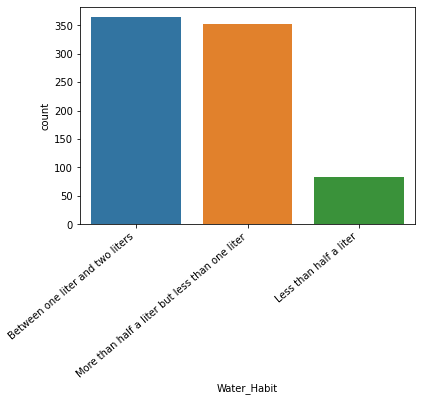

In [ ]:
water=sns.countplot(x=data_habits["Water_Habit"], order=['Between one liter and two liters',
       'More than half a liter but less than one liter',
       'Less than half a liter'])
water.set_xticklabels(water.get_xticklabels(), rotation=40, ha="right")

plt.show()

Text(0.5, 0.98, 'Discriminative power of Habits features')

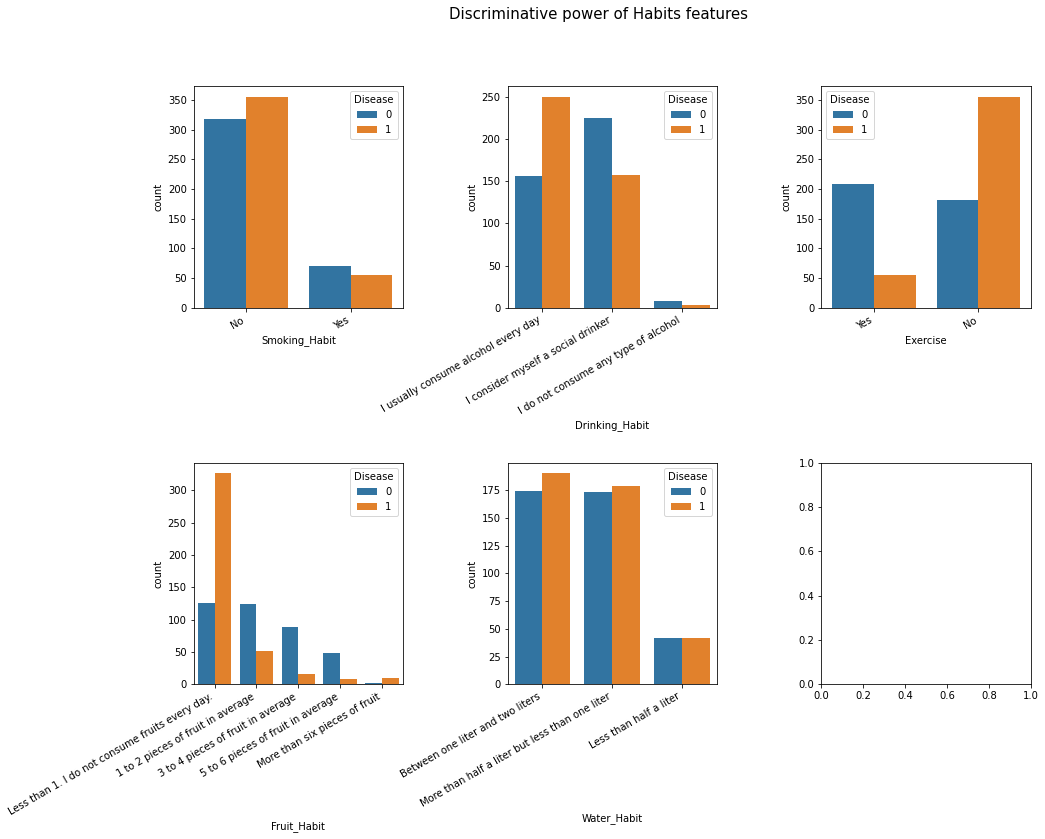

In [ ]:
data_habits_disease = data_habits.copy()
data_habits_disease['Disease'] = y

fig, axes = plt.subplots(2, ceil(len(data_habits.columns) / 2), figsize=(15, 11))

plt.subplots_adjust(hspace=0.7, wspace=0.5)

for ax, feat in zip(axes.flatten(), data_habits.columns):
  p = sns.countplot(data=data_habits_disease, x=feat, hue='Disease', ax=ax)
  p.set_xticklabels(p.get_xticklabels(), rotation= 30, ha="right")

plt.suptitle('Discriminative power of Habits features', fontsize = 15) 

Exercise, Fruit Habit e Drinking Habit look like having a higher discriminative power.

### **Demo** <a class="anchor" id="demo"></a>

#### General overview

In [ ]:
data_demo.head()

,Name,Birth_Year,Region,Education,Disease
PatientID,,,,,
1167,Mrs. Stephanie Gay,1965,London,High School Incomplete (10th to 11th grade),1
1805,Mr. Sherman Nero,1969,South West,High School Incomplete (10th to 11th grade),1
1557,Mr. Mark Boller,1974,Yorkshire and the Humber,Elementary School (1st to 9th grade),1
1658,Mr. David Caffee,1958,London,University Complete (3 or more years),0
1544,Mr. Gerald Emery,1968,South East,University Incomplete (1 to 2 years),1


In [ ]:
data_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1167 to 1117
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        800 non-null    object
 1   Birth_Year  800 non-null    int64 
 2   Region      800 non-null    object
 3   Education   787 non-null    object
 4   Disease     800 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 37.5+ KB


In [ ]:
data_demo.describe(include = 'all')

,Name,Birth_Year,Region,Education,Disease
count,800,800.000000,800,787,800.000000
unique,799,NaN,10,6,NaN
top,Mr. Gary Miller,NaN,East Midlands,University Complete (3 or more years),NaN
freq,2,NaN,154,239,NaN
mean,NaN,1966.043750,NaN,NaN,0.513750
std,NaN,15.421872,NaN,NaN,0.500124
min,NaN,1855.000000,NaN,NaN,0.000000
25%,NaN,1961.000000,NaN,NaN,0.000000
50%,NaN,1966.000000,NaN,NaN,1.000000
75%,NaN,1974.000000,NaN,NaN,1.000000


In [ ]:
print('There are',data_demo.duplicated().sum(), 'duplicates in the demo dataset')

There are 0 duplicates in the demo dataset


Check if we have unbalance data


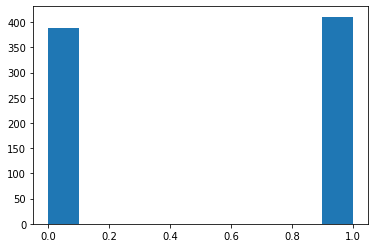

In [ ]:
plt.hist(y)
plt.show()
# data is not umbalanced

Data is well balanced on the target variable

#### Visualizations

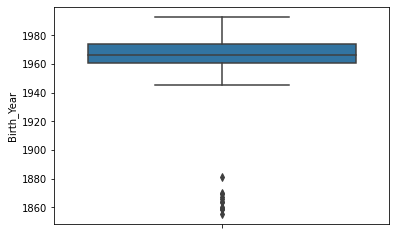

In [ ]:
sns.boxplot(y=data_demo["Birth_Year"])
plt.show()

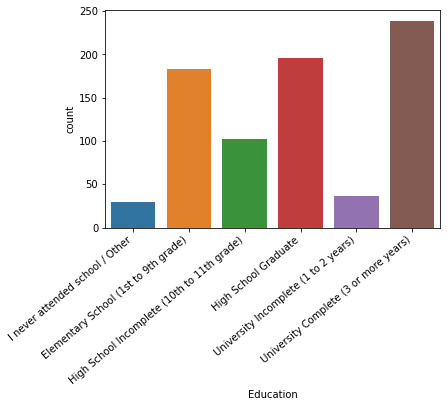

In [ ]:
educ_grapgh=sns.countplot(x=data_demo["Education"], order=['I never attended school / Other','Elementary School (1st to 9th grade)','High School Incomplete (10th to 11th grade)','High School Graduate','University Incomplete (1 to 2 years)','University Complete (3 or more years)'])
educ_grapgh.set_xticklabels(educ_grapgh.get_xticklabels(), rotation=40, ha="right")

plt.show()

In [ ]:
data_demo.groupby(["Education","Disease"]).count()['Name']

#All education levels have people that catch and didn't catch the parasite

Education                                    Disease
Elementary School (1st to 9th grade)         0           78
                                             1          105
High School Graduate                         0          107
                                             1           89
High School Incomplete (10th to 11th grade)  0           55
                                             1           47
I never attended school / Other              0           13
                                             1           17
University Complete (3 or more years)        0          116
                                             1          123
University Incomplete (1 to 2 years)         0           15
                                             1           22
Name: Name, dtype: int64

In [ ]:
data_demo.groupby(["Region","Disease"]).count()['Name']

#All regions have people that catch and didn't catch the parasite

Region                    Disease
East Midlands             0          78
                          1          76
East of England           0          39
                          1          41
LONDON                    0           1
                          1           4
London                    0          67
                          1          69
North East                0          12
                          1          10
North West                0          32
                          1          27
South East                0          41
                          1          43
South West                0          49
                          1          58
West Midlands             0          40
                          1          49
Yorkshire and the Humber  0          30
                          1          34
Name: Name, dtype: int64

In [ ]:
data_demo[data_demo.isnull().any(axis=1)]

#Missing data. Drop or inpute later

,Name,Birth_Year,Region,Education,Disease
PatientID,,,,,
1653,Mr. David Lamothe,1966,East Midlands,NaN,0
1085,Mr. Robert Swenson,1978,South West,NaN,1
1048,Mrs. Margaret Wysong,1956,East Midlands,NaN,1
1128,Mr. John Castillo,1970,South East,NaN,1
1241,Mr. Tommy Jenkins,1955,London,NaN,0
1195,Mr. John Hess,1963,London,NaN,1
1296,Mr. Terry Roberts,1955,South East,NaN,0
1904,Mr. Manuel Rothwell,1967,East Midlands,NaN,1
1664,Mrs. Jan Campbell,1956,East Midlands,NaN,1


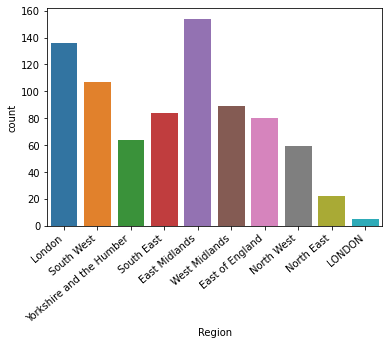

In [ ]:
reg_graph=sns.countplot(x=data_demo["Region"])
reg_graph.set_xticklabels(reg_graph.get_xticklabels(), rotation=40, ha="right")

plt.show()
#there are two londons ; it is an inconsistency that will be later treated 

#### Problem fixing

In [ ]:
data_demo['Region'] = data_demo['Region'] .replace({'LONDON' : 'London'}, regex=True)
data_demo['Region'].value_counts()

East Midlands               154
London                      141
South West                  107
West Midlands                89
South East                   84
East of England              80
Yorkshire and the Humber     64
North West                   59
North East                   22
Name: Region, dtype: int64

#### Check outliers

In [ ]:
data_demo[data_demo['Birth_Year'] < 1900]

,Name,Birth_Year,Region,Education,Disease
PatientID,,,,,
1591,Mrs. Ashley Pena,1859,Yorkshire and the Humber,Elementary School (1st to 9th grade),0
1481,Mrs. Lisa Cooks,1859,East Midlands,High School Graduate,0
1288,Mrs. Minnie Hirschfeld,1864,Yorkshire and the Humber,High School Incomplete (10th to 11th grade),1
1139,Mr. Gary Baca,1881,East Midlands,University Incomplete (1 to 2 years),1
1158,Mrs. Mary Hollingsworth,1855,South West,Elementary School (1st to 9th grade),1
1593,Mrs. Nicole Ronin,1859,North East,Elementary School (1st to 9th grade),0
1055,Mr. Douglas Salters,1867,East Midlands,Elementary School (1st to 9th grade),0
1836,Mrs. Sharyn Furst,1869,West Midlands,High School Graduate,1
1803,Mr. Kenneth Ferraro,1870,East of England,High School Graduate,0


# Preprocessing steps <a class="anchor" id="preprocessing"></a>

Join all the data into one dataframe

In [ ]:
data_demo = data_demo.drop(['Disease'], axis = 1)
data = pd.concat([data_health, data_habits, data_demo], axis = 1, join = 'inner')

In [ ]:
data_with_target = pd.concat([data, y], axis = 1, join = 'inner')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1167 to 1117
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Height            800 non-null    int64 
 1   Weight            800 non-null    int64 
 2   High_Cholesterol  800 non-null    int64 
 3   Blood_Pressure    800 non-null    int64 
 4   Mental_Health     800 non-null    int64 
 5   Physical_Health   800 non-null    int64 
 6   Checkup           800 non-null    object
 7   Diabetes          800 non-null    object
 8   Smoking_Habit     800 non-null    object
 9   Drinking_Habit    800 non-null    object
 10  Exercise          800 non-null    object
 11  Fruit_Habit       800 non-null    object
 12  Water_Habit       800 non-null    object
 13  Name              800 non-null    object
 14  Birth_Year        800 non-null    int64 
 15  Region            800 non-null    object
 16  Education         787 non-null    object
dtypes: int64(7),

### Outliers <a class="anchor" id="outliers"></a>

In [ ]:
# drop outliers birth year
y.drop(data[data['Birth_Year'] < 1900] .index, inplace = True)
data.drop(data[data['Birth_Year'] < 1900] .index, inplace = True)

In [ ]:
data.shape

(788, 17)

In [ ]:
y.shape

(788,)

### Types conversion <a class="anchor" id="types"></a>

In [ ]:
def types_conversion(df):
  df['Smoking_Habit'] = df['Smoking_Habit'].map({'Yes': 1, 'No': 0})
  df['Exercise'] = df['Exercise'].map({'Yes' : 1, 'No' : 0})

  return df

data = types_conversion(data)

data.head()

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Name,Birth_Year,Region,Education
PatientID,,,,,,,,,,,,,,,,,
1167,155,67,358,120,21,2,More than 3 years,Neither I nor my immediate family have diabetes.,0,I usually consume alcohol every day,1,Less than 1. I do not consume fruits every day.,Between one liter and two liters,Mrs. Stephanie Gay,1965,London,High School Incomplete (10th to 11th grade)
1805,173,88,230,142,9,0,Not sure,Neither I nor my immediate family have diabetes.,0,I consider myself a social drinker,1,Less than 1. I do not consume fruits every day.,Between one liter and two liters,Mr. Sherman Nero,1969,South West,High School Incomplete (10th to 11th grade)
1557,162,68,226,122,26,0,More than 3 years,Neither I nor my immediate family have diabetes.,0,I consider myself a social drinker,0,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,Mr. Mark Boller,1974,Yorkshire and the Humber,Elementary School (1st to 9th grade)
1658,180,66,313,125,13,8,Not sure,I have/had pregnancy diabetes or borderline di...,0,I usually consume alcohol every day,1,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,Mr. David Caffee,1958,London,University Complete (3 or more years)
1544,180,58,277,125,18,2,More than 3 years,I have/had pregnancy diabetes or borderline di...,0,I consider myself a social drinker,0,1 to 2 pieces of fruit in average,More than half a liter but less than one liter,Mr. Gerald Emery,1968,South East,University Incomplete (1 to 2 years)


In [ ]:
data_test = types_conversion(data_test)

### Enconding of ordinal features <a class="anchor" id="ordinal"></a>

In [ ]:
def encode_ordinal(df):
  df['Years_Studied'] = df['Education'].map({'I never attended school / Other' : 0, \
                                                     'Elementary School (1st to 9th grade)' : 9, \
                                                     'High School Incomplete (10th to 11th grade)': 10.5, \
                                                     'High School Graduate': 12, \
                                                     'University Incomplete (1 to 2 years)': 13.5, \
                                                     'University Complete (3 or more years)': 15})
  df.drop(['Education'], axis = 1, inplace = True)

  df['Drinking_Habit'] = df['Drinking_Habit'].map({'I usually consume alcohol every day' : 2, \
                                                                   'I consider myself a social drinker' : 1, \
                                                                   'I do not consume any type of alcohol' : 0})
  
  df['Fruit_Habit'] = df['Fruit_Habit'].map({'Less than 1. I do not consume fruits every day.' : 0.5, \
                                                             '1 to 2 pieces of fruit in average' : 1.5, \
                                                             '3 to 4 pieces of fruit in average' : 3.5, \
                                                             '5 to 6 pieces of fruit in average': 5.5, \
                                                             'More than six pieces of fruit' : 6})
  
  df['Water_Habit'] = df['Water_Habit'].map({'Less than half a liter' : 0.25, \
                                                             'More than half a liter but less than one liter' : 0.75, \
                                                             'Between one liter and two liters' :1.5})
  return df

In [ ]:
data = encode_ordinal(data)

In [ ]:
data_test = encode_ordinal(data_test)

In [ ]:
data['Years_Studied'].value_counts()

15.0    239
12.0    193
9.0     177
10.5    101
13.5     36
0.0      30
Name: Years_Studied, dtype: int64

### Feature Engineering <a class="anchor" id="feature_eng"></a>

In [ ]:
data['Female']=np.where(data['Name'].str.startswith('Mrs.'),1,0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788 entries, 1167 to 1117
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Height            788 non-null    int64  
 1   Weight            788 non-null    int64  
 2   High_Cholesterol  788 non-null    int64  
 3   Blood_Pressure    788 non-null    int64  
 4   Mental_Health     788 non-null    int64  
 5   Physical_Health   788 non-null    int64  
 6   Checkup           788 non-null    object 
 7   Diabetes          788 non-null    object 
 8   Smoking_Habit     788 non-null    int64  
 9   Drinking_Habit    788 non-null    int64  
 10  Exercise          788 non-null    int64  
 11  Fruit_Habit       788 non-null    float64
 12  Water_Habit       788 non-null    float64
 13  Name              788 non-null    object 
 14  Birth_Year        788 non-null    int64  
 15  Region            788 non-null    object 
 16  Years_Studied     776 non-null    float6

In [ ]:
data.drop(['Name'], axis = 1, inplace = True)

In [ ]:
data_test['Female']=np.where(data_test['Name'].str.startswith('Mrs.'),1,0)
data_test.drop(['Name'], axis = 1, inplace = True)

In [ ]:
data_with_target['Female'] = data['Female']
data_with_target.groupby("Female")["Disease"].value_counts(normalize = True)
# Women seam to be more prone to catch the disease -> probably a feature to keep

Female  Disease
0.0     0          0.578571
        1          0.421429
1.0     1          0.750000
        0          0.250000
Name: Disease, dtype: float64

## Scaling <a class="anchor" id="scaling"></a>

In [ ]:
def scale(X_train, X_test):
  scaler = MinMaxScaler(feature_range = (-1, 1))
  X_train_scaled = scaler.fit_transform(X_train)
  X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns).set_index(X_train.index)

  X_test_scaled = scaler.transform(X_test)
  X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns).set_index(X_test.index)
  
  return X_train, X_test

## Missing values <a class="anchor" id="missing"></a>

In [ ]:
data.isnull().sum()

Height               0
Weight               0
High_Cholesterol     0
Blood_Pressure       0
Mental_Health        0
Physical_Health      0
Checkup              0
Diabetes             0
Smoking_Habit        0
Drinking_Habit       0
Exercise             0
Fruit_Habit          0
Water_Habit          0
Birth_Year           0
Region               0
Years_Studied       12
Female               0
dtype: int64

There were only missing values on the feature 'YearsStudied'
We decided to fill the missing values with KNNImputer using only Birth_year and Female to calculate proximity wuth neighbours. We believe that people with similar ages and gender should have studied a similar number of years.

In [ ]:
def fill_missing_values(X_train, X_val):
  X_train_demo = X_train[['Birth_Year', 'Female', 'Years_Studied']]
  imputer = KNNImputer()

  X_train_filled = imputer.fit_transform(X_train_demo)
  X_train.loc[:, ['Birth_Year', 'Female', 'Years_Studied']] = pd.DataFrame(X_train_filled, columns = X_train_demo.columns).set_index(X_train_demo.index)

  X_val_temp_filled = imputer.transform(X_val[['Birth_Year', 'Female', 'Years_Studied']])
  X_val.loc[:, ['Birth_Year', 'Female', 'Years_Studied']] = pd.DataFrame(X_val_temp_filled, columns = X_train_demo.columns).set_index(X_val.index)

  return X_train, X_val

## Feature Selection <a class="anchor" id="f_selection"></a>

### Filter methods <a class="anchor" id="filter"></a>

#### Univariate variables <a class="anchor" id="univariate"></a>

In [ ]:
def univariate_variables(X_train):
  feat_no_var = X_train.var().loc[X_train.var() == 0].index.values
  return feat_no_var

#### Chi2 for Categorical Variables <a class="anchor" id="chi2"></a>

In [ ]:
def check_independence(X,y,var,alpha=0.05):        
    df_observed = pd.crosstab(y,X) 
    chi2, p, dof, expected = st.chi2_contingency(df_observed.values)
    if p<alpha:
        return 1
    else:
        return 0

In [ ]:
def chi_squared_score(X_train_cat, y_train):
  """
    Function that selects important categorical variables using the Chi2 ststistical test
  """
  selected_vars = []
  # for each feature test importance using chi squared
  for var in X_train_cat:
    res = check_independence(X_train_cat[var],y_train, var)
    if res == 1:
      # if feature is important append to selected features
      selected_vars.append(var)
  return selected_vars


#### Mutual information for Numerical Variables <a class="anchor" id="mutual_info"></a>

mutual_info_classif can capture any kind of relationship (for example: linear, quadratic and exponential). So, in general, mutual_info is more robust and more versatile than f_. If we have no idea about which types of relationships can predictors have with the target, mutual_info is usually preferred over f_.

In [ ]:
np.random.seed(20)
random.seed(20)

def mutual_info_score(X_train_num, y_train):
  """
    Function that selects the 8 most important features according to mutual_info_classif
  """
  bestfeatures = SelectKBest(score_func=mutual_info_classif, k=8)
  bestfeatures.fit(X_train_num,y_train)

  cols = bestfeatures.get_support(indices=True)
  selected_columns = X_train_num.iloc[:,cols].columns.tolist()

  return selected_columns

#### Spearman Correlation <a class="anchor" id="spearman"></a>


In [ ]:
def spearman_corr(X, y):
  """
    Funtion that selects features with correlation with the target higher than 0.75
  """
  data_with_target = X.join(y)

  cor_spearman = data_with_target.corr(method = 'spearman')

  return cor_spearman[np.abs(cor_spearman['Disease']) > 0.75].index.values

### Wrapper methods - RFE <a class="anchor" id="rfe"></a>


In [ ]:
def rfe_selection(X_train, y_train, X_val, y_val):
  """
    Function that selects the K most important features according to RFE.
    The k is dinamically choosen by calculating the scores of the model with values of K ranging from 1 to the number of features.
  """
  nr_features_list = list(range(1, len(X_train.columns) +1))
  highest_score=0

  score_list = []

  # to select the best nr of features to keep
  for n in nr_features_list:
    # create model for the RFE to use
    model = DecisionTreeClassifier(random_state = 20)

    # create RFE object to select the best n features
    rfe = RFE(estimator = model, n_features_to_select = n)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_val_rfe = rfe.transform(X_val)
    model.fit(X_train_rfe,y_train)
    
    # model score
    y_pred = model.predict(X_val_rfe)
    score = f1_score(y_val, y_pred)
    score_list.append(score)
    
    # select the number of features that show the highest score
    if(score>highest_score):
      selected_features = X_train.columns[rfe.support_].values
      highest_score = score

  return selected_features

### Embedded methods - Lasso regularization <a class="anchor" id="lasso"></a>

In [ ]:
def lasso_selection(X_train, y_train):
  """
    Function that uses lasso regularization on a SVM to select features with coeffiecients greater than 0.1
  """
  lsvc = LinearSVC(C=0.1, penalty="l1", dual=False, random_state = 20).fit(X_train, y_train)

  # coefficients of lasso
  coef = pd.Series(lsvc.coef_.ravel(), index = X_train.columns)

  # select only the features with weight greater then 0.1
  selected = X_train.columns[np.abs(coef) > 0.1].values

  return selected

## Transforming categorical variables <a class="anchor" id="categorical"></a>

In [ ]:
def replace_by_mean(df_with_target, column, df):

    # Column | Disease
    # cat1   | 0.4
    # cat2   | 0.24
    # ...
    g1 = df_with_target.groupby([column]).mean() # we get the mean of disease by category

    # for each category of that column
    for category, row in g1.iterrows():
      # replace every category by the mean of disease per category
      df.loc[df[column] == category, column] = row['Disease']

    return df

# Model Selection and Evaluation <a class="anchor" id="model_selection"></a>

In [ ]:
np.random.seed(20)
random.seed(20)

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 20)

models = ['LogisticReg', 'KNN', 'DecisionTree', 'SVM', 'NaiveBayes', 'QDA', 'BaggingClassifier', 'RandomForest', 'AdaBoost', 'GradBoost',  'MLP']

# {'feat1': [3, 3, 3, 1, 3], 'feat2': [3, 2, 2, 3, 3], 'feat3': [1, 1, 0, 0, 2] ...} -> for each fold, nr of times a feature is selected
features_dict = {}

# to save the train and validation scoees in each fold for each model
models_train_score = {}
models_val_score = {}

for feat in data.columns:
  features_dict[feat] = []

for model in models:
  models_train_score[model] = []
  models_val_score[model] = []


for train_index, val_index in skf.split(data, y):

  X_train, X_val = data.iloc[train_index], data.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  # --------------------------------------------------------#
  #                    Split the data                       #
  # --------------------------------------------------------#
  X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)
  X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)

  X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
  X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

  # --------------------------------------------------------#
  #                        Scaling                          #
  # --------------------------------------------------------#
  X_train_num, X_val_num = scale(X_train_num, X_val_num)

  # --------------------------------------------------------#
  #                     Missing Values                      #
  # --------------------------------------------------------#
  X_train_num, X_val_num = fill_missing_values(X_train_num, X_val_num)

  # --------------------------------------------------------#
  #                   Feature Selection                     #
  # --------------------------------------------------------#

  # {'feat1': 4, 'feat2': 3, 'feat3': 1 ...} -> nr of times a feature is selected by a feature selection method in this fold
  features_cat = {}
  for feat in X_train_cat.columns:
    features_cat[feat] = 0

  features_num = {}
  for feat in X_train_num.columns:
    features_num[feat] = 0 

  # --------------------- Filter Methods ------------------ #

  # Drop univariate variables
  feat_no_var = univariate_variables(X_train_num) # returns univariate features
  for feat in feat_no_var:
    X_train_num.drop(feat, axis = 1, inplace = True)
    X_val_num.drop(feat, axis = 1, inplace = True)


  # Mutual info for numerical variables
  selected_feat = mutual_info_score(X_train_num, y_train) # returns selected features
  for feat in selected_feat:
    features_num[feat] += 1

  # Spearman correlation
  selected_feat = spearman_corr(X_train_num, y_train)
  for feat in selected_feat:
    if feat == 'Disease':
      continue
    features_num[feat] += 1

  # Chi Squared for categorical variables
  selected_feat = chi_squared_score(X_train_cat, y_train) # returns selected features
  for feat in selected_feat:
      features_cat[feat] += 1


  # -------------------- Wrapper Methods ----------------- #
  selected_feat = rfe_selection(X_train_num, y_train, X_val_num, y_val)
  for feat in selected_feat:
    features_num[feat] += 1

  # ------------------ Embedded Methods ------------------ #  
  # SVM with lasso regularization
  selected_feat = lasso_selection(X_train_num, y_train)
  for feat in selected_feat:
    features_num[feat] += 1

   # ------------- Perform feature selection ------------- #

  # add nr of times each feature was selected by a method in this fold to the global dictionaty
  for feat in features_num:
    features_dict[feat].append(features_num[feat])
  for feat in features_cat:
    features_dict[feat].append(features_cat[feat])

  discard_num = []
  discard_cat = []

  # selection of features
  for feat in features_num:
    # we have 4 methods of feature selection but spearman correlation will almost always
    # not select anything so we are left with 3 real informative methods
    # we choose to keep only the features that were selected by at least 2 methods
    if features_num[feat] < 2:
      discard_num.append(feat)

  for feat in features_cat:
    # we just have 1 method to select categorical features
    # we keep the features that were selected by the chi2 method
    if features_cat[feat] == 0:
      discard_cat.append(feat)

  # drop features to discard
  X_train_num.drop(discard_num, axis = 1, inplace = True)
  X_train_cat.drop(discard_cat, axis = 1, inplace = True)
  X_val_num.drop(discard_num, axis = 1, inplace = True)
  X_val_cat.drop(discard_cat, axis = 1, inplace = True)

  # --------------------------------------------------------#
  #            Transforming Categorical Variables           #
  # --------------------------------------------------------#
  X_train_cat_with_target = pd.concat([X_train_cat, y_train], axis = 1, join = 'inner')

  for col in X_train_cat.columns:
    X_train_cat = replace_by_mean(X_train_cat_with_target, col, X_train_cat)

  for col in X_val_cat.columns:
    X_val_cat = replace_by_mean(X_train_cat_with_target, col, X_val_cat)

  # --------------------------------------------------------#
  #              Join all data into one dataset             #
  # --------------------------------------------------------#
  X_train = pd.concat([X_train_num, X_train_cat], axis = 1, join = 'inner')
  X_val = pd.concat([X_val_num, X_val_cat], axis = 1, join = 'inner')

  # --------------------------------------------------------#
  #                     Model evaluation                    #
  # --------------------------------------------------------#

  # Logistic Regression
  logistic_clf = LogisticRegression(random_state=20).fit(X_train, y_train)
  y_pred = logistic_clf.predict(X_train)
  models_train_score['LogisticReg'].append(f1_score(y_train, y_pred))

  y_pred = logistic_clf.predict(X_val)
  models_val_score['LogisticReg'].append(f1_score(y_val, y_pred))

  # KNN
  KNN_clf = KNeighborsClassifier().fit(X_train, y_train)
  y_pred = KNN_clf.predict(X_train)
  models_train_score['KNN'].append(f1_score(y_train, y_pred))

  y_pred = KNN_clf.predict(X_val)
  models_val_score['KNN'].append(f1_score(y_val, y_pred))

  # Decision Tree
  tree_clf = DecisionTreeClassifier(random_state = 20).fit(X_train, y_train)
  y_pred = tree_clf.predict(X_train)
  models_train_score['DecisionTree'].append(f1_score(y_train, y_pred))

  y_pred = tree_clf.predict(X_val)
  models_val_score['DecisionTree'].append(f1_score(y_val, y_pred))

  # SVM
  svm_clf = SVC(random_state = 20).fit(X_train, y_train)
  y_pred = svm_clf.predict(X_train)
  models_train_score['SVM'].append(f1_score(y_train, y_pred))

  y_pred = svm_clf.predict(X_val)
  models_val_score['SVM'].append(f1_score(y_val, y_pred))

  # GaussianNB
  nb_clf = GaussianNB().fit(X_train, y_train)
  y_pred = nb_clf.predict(X_train)
  models_train_score['NaiveBayes'].append(f1_score(y_train, y_pred))

  y_pred = nb_clf.predict(X_val)
  models_val_score['NaiveBayes'].append(f1_score(y_val, y_pred))

  # QDA
  qda_clf = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
  y_pred = qda_clf.predict(X_train)
  models_train_score['QDA'].append(f1_score(y_train, y_pred))

  y_pred = qda_clf.predict(X_val)
  models_val_score['QDA'].append(f1_score(y_val, y_pred))

  # BaggingClassifier
  bagging_clf = BaggingClassifier(random_state = 20).fit(X_train, y_train)
  y_pred = bagging_clf.predict(X_train)
  models_train_score['BaggingClassifier'].append(f1_score(y_train, y_pred))

  y_pred = bagging_clf.predict(X_val)
  models_val_score['BaggingClassifier'].append(f1_score(y_val, y_pred))

  # Random Forest -> specific type of bagging
  forest_clf = RandomForestClassifier(random_state=20).fit(X_train, y_train)
  y_pred = forest_clf.predict(X_train)
  models_train_score['RandomForest'].append(f1_score(y_train, y_pred))

  y_pred = forest_clf.predict(X_val)
  models_val_score['RandomForest'].append(f1_score(y_val, y_pred))

  # Adaptive Boosting with Decision Tree
  adaboost_clf = AdaBoostClassifier(random_state = 20).fit(X_train, y_train)
  y_pred = adaboost_clf.predict(X_train)
  models_train_score['AdaBoost'].append(f1_score(y_train, y_pred))

  y_pred = adaboost_clf.predict(X_val)
  models_val_score['AdaBoost'].append(f1_score(y_val, y_pred))

  # Gradient Boosting
  grad_clf = GradientBoostingClassifier(random_state = 20).fit(X_train, y_train)
  y_pred = grad_clf.predict(X_train)
  models_train_score['GradBoost'].append(f1_score(y_train, y_pred))

  y_pred = grad_clf.predict(X_val)
  models_val_score['GradBoost'].append(f1_score(y_val, y_pred))

  # MLP
  mlp_clf = MLPClassifier(hidden_layer_sizes = (100, 100, 100), random_state = 20).fit(X_train, y_train)
  y_pred = mlp_clf.predict(X_train)
  models_train_score['MLP'].append(f1_score(y_train, y_pred))

  y_pred = mlp_clf.predict(X_val)
  models_val_score['MLP'].append(f1_score(y_val, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Auxiliary functions to color the results
def color_results(cell):
  value = float(cell.split('+')[0])

  if value >= 0.95:
    return 'background-color:  #73d037'
    color = 'green'
  elif value > 0.9:
    return 'background-color:  #ebe448'
  else:
    return ''

def color_letters(cell):
  value = float(cell.split('+')[0])

  if value > 0.9:
    return 'color: black'
  else:
    return 'color: white'


def show_models_results(train_scores, val_scores):
  df = pd.DataFrame(columns = ['Train', 'Val'], index = train_scores.keys())
  
  for model, scores in train_scores.items():
    df.loc[model, 'Train'] = str(round(np.mean(train_scores[model]),3)) + '+/-' + str(round(np.std(train_scores[model]),2))
    df.loc[model, 'Val'] = str(round(np.mean(val_scores[model]),3)) + '+/-' + str(round(np.std(val_scores[model]),2))

  return df

In [ ]:
df = show_models_results(models_train_score, models_val_score)

df.style.applymap(color_results).applymap(color_letters)

,Train,Val
LogisticReg,0.854+/-0.01,0.838+/-0.02
KNN,0.929+/-0.01,0.851+/-0.03
DecisionTree,1.0+/-0.0,0.965+/-0.02
SVM,0.882+/-0.01,0.857+/-0.03
NaiveBayes,0.847+/-0.01,0.842+/-0.01
QDA,0.855+/-0.01,0.842+/-0.03
BaggingClassifier,0.998+/-0.0,0.976+/-0.01
RandomForest,1.0+/-0.0,0.989+/-0.01
AdaBoost,0.921+/-0.01,0.888+/-0.02
GradBoost,0.984+/-0.0,0.943+/-0.02


DecisionTree, Bagging, RandomForest, GradBoost and MLP are the models with the greatest potential. We have choosen to go into a deeper tuning of three of these: Random Forest, GradBoost and MLP. We decided not to go further with the general bagging classifer because the RandomForest is a specific type of bagging model and showed better results than this one. Also, a RandomForest is always more robust than a simple DecisionTree, so we decided also not to go into further further analysis of the latest.

Linear models such as linear regression probably do not work well because the data is not linearly separable. For these models to work, the data would have to be transformed in such a way that it would become linearly separable. However, this feature engineering task is really dificult to do 'by hand', and there are models that already do this, such as MLP and SVM. We can see this by looking at the sightly higher score of an SVM with 'rbf' as kernel and also to MLP score, which is really high.

# Final data preprocessing <a class="anchor" id="final_preprocessing"></a>

### Remove irrelevant features

#### Split into numerical and categorical

In [ ]:
data_num = data.select_dtypes(include=np.number).set_index(data.index)
data_cat = data.select_dtypes(exclude=np.number).set_index(data.index)

In [ ]:
data_test_num = data_test.select_dtypes(include=np.number).set_index(data_test.index)
data_test_cat = data_test.select_dtypes(exclude=np.number).set_index(data_test.index)

#### Choosing features based on the ones most choosen in KFold

In [ ]:
features_dict

{'Height': [0, 1, 1, 0, 0],
 'Weight': [1, 2, 1, 0, 1],
 'High_Cholesterol': [3, 3, 2, 3, 2],
 'Blood_Pressure': [2, 3, 3, 3, 2],
 'Mental_Health': [3, 3, 3, 3, 3],
 'Physical_Health': [3, 3, 3, 3, 3],
 'Checkup': [1, 1, 1, 1, 1],
 'Diabetes': [1, 1, 1, 1, 1],
 'Smoking_Habit': [0, 0, 0, 0, 0],
 'Drinking_Habit': [0, 1, 1, 2, 1],
 'Exercise': [3, 3, 3, 3, 2],
 'Fruit_Habit': [3, 3, 3, 3, 3],
 'Water_Habit': [0, 0, 0, 0, 1],
 'Birth_Year': [2, 3, 2, 2, 2],
 'Region': [0, 0, 0, 0, 0],
 'Years_Studied': [0, 0, 0, 0, 1],
 'Female': [2, 2, 3, 2, 1]}

In [ ]:
for feat in features_dict:
  features_dict[feat] = st.mode(features_dict[feat])[0][0]

features_dict

{'Height': 0,
 'Weight': 1,
 'High_Cholesterol': 3,
 'Blood_Pressure': 3,
 'Mental_Health': 3,
 'Physical_Health': 3,
 'Checkup': 1,
 'Diabetes': 1,
 'Smoking_Habit': 0,
 'Drinking_Habit': 1,
 'Exercise': 3,
 'Fruit_Habit': 3,
 'Water_Habit': 0,
 'Birth_Year': 2,
 'Region': 0,
 'Years_Studied': 0,
 'Female': 2}

In [ ]:
discard_num = []
discard_cat = []

for feat in features_dict:
  # discard numerical variable if choosen less than 2 times in the majority of the folds
  if (feat in data_num.columns) and (features_dict[feat] < 2):
    discard_num.append(feat)
  # discrd categorical variable if not choosen in the majority of the folds
  elif (feat in data_cat.columns) and (features_dict[feat] == 0):
    discard_cat.append(feat)

In [ ]:
discard_num

['Height',
 'Weight',
 'Smoking_Habit',
 'Drinking_Habit',
 'Water_Habit',
 'Years_Studied']

In [ ]:
discard_cat

['Region']

#### Drop features that are not considered important

In [ ]:
data_num.drop(discard_num, axis = 1, inplace = True)
data_cat.drop(discard_cat, axis = 1, inplace = True)

data_test_num.drop(discard_num, axis = 1, inplace = True)
data_test_cat.drop(discard_cat, axis = 1, inplace = True)

In [ ]:
data = pd.concat([data_num, data_cat], axis = 1, join = 'inner')

In [ ]:
data.isna().sum()

# the is no need to fill the missing values anymore

High_Cholesterol    0
Blood_Pressure      0
Mental_Health       0
Physical_Health     0
Exercise            0
Fruit_Habit         0
Birth_Year          0
Female              0
Checkup             0
Diabetes            0
dtype: int64

In [ ]:
data.head() # this dataset, without the following preprocessing steps done, is going to be used in the individual parameters fine tuning with CV

,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Exercise,Fruit_Habit,Birth_Year,Female,Checkup,Diabetes
PatientID,,,,,,,,,,
1167,358,120,21,2,1,0.5,1965,1,More than 3 years,Neither I nor my immediate family have diabetes.
1805,230,142,9,0,1,0.5,1969,0,Not sure,Neither I nor my immediate family have diabetes.
1557,226,122,26,0,0,0.5,1974,0,More than 3 years,Neither I nor my immediate family have diabetes.
1658,313,125,13,8,1,0.5,1958,0,Not sure,I have/had pregnancy diabetes or borderline di...
1544,277,125,18,2,0,1.5,1968,0,More than 3 years,I have/had pregnancy diabetes or borderline di...


## Scaling

In [ ]:
data_num, data_test_num = scale(data_num, data_test_num)

## Transforming categorical features

In [ ]:
data_cat_with_target = pd.concat([data_cat, y_train], axis = 1, join = 'inner')

for col in data_cat.columns:
  replace_by_mean(data_cat_with_target, col, data_cat)

for col in data_cat.columns:
  replace_by_mean(data_cat_with_target, col, data_test_cat)

In [ ]:
data_preprocessed = pd.concat([data_num, data_cat], axis = 1, join = 'inner')

data_test = pd.concat([data_test_num, data_test_cat], axis = 1, join = 'inner')

# Models fine tuning <a class="anchor" id="finetuning"></a>

In [ ]:
def compare_parameters(X, y, models, mlp = False):
  """
    Auxiliary function that splits data using a StratifiedKFold and performs some preprocessing in each fold
    (scaling and conversion of categorical features to ratios).
    Finally, each model is trained and the scores of both training and validation sets are stored and then averaged in the end

    Inputs: the data X and y, the models to be tested and a flag in case models are MLPs to also count the nr of iterations
  """

  df = pd.DataFrame(index = models.keys(), columns = ['Train', 'Val'])

  if mlp:
    df['Iterations'] = 0

  for name, model in models.items():
    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 20)

    train_scores = []
    val_scores = []
    nr_iter = []
    
    for train_index, val_index in skf.split(X,y):
      X_train, X_val = X.iloc[train_index], X.iloc[val_index]
      y_train, y_val = y.iloc[train_index], y.iloc[val_index]

      # ---------- Split into num and categorical ----------- #
      
      X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)
      X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)

      X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
      X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

      # ----------------------- Scaling --------------------- #

      X_train_num, X_val_num = scale(X_train_num, X_val_num)

      # ---------- Replace categorical features by mean ----------- #

      X_train_cat_with_target = pd.concat([X_train_cat, y_train], axis = 1, join = 'inner')

      for col in X_train_cat.columns:
        X_train_cat = replace_by_mean(X_train_cat_with_target, col, X_train_cat)
      
      for col in X_val_cat.columns:
        X_val_cat = replace_by_mean(X_train_cat_with_target, col, X_val_cat)

      # --------------- Join all datasets again ------------- #

      X_train = pd.concat([X_train_num, X_train_cat], axis = 1, join = 'inner')
      X_val = pd.concat([X_val_num, X_val_cat], axis = 1, join = 'inner')

      # ------------------- Model traning ------------------- #

      model.fit(X_train, y_train)

      # ---------------------- Scores ----------------------- #

      y_pred = model.predict(X_train)
      train_scores.append(f1_score(y_train, y_pred))

      y_pred = model.predict(X_val)
      val_scores.append(f1_score(y_val, y_pred))

      if mlp:
        nr_iter.append(model.n_iter_)

    avg_train = str(round(np.mean(train_scores), 3)) + '+/-' + str(round(np.std(train_scores), 2))
    avg_val = str(round(np.mean(val_scores), 3)) + '+/-' + str(round(np.std(val_scores), 2))

    if mlp:
      avg_iter = str(round(np.mean(nr_iter), 3)) + '+/-' + str(round(np.std(nr_iter), 2))
      df.loc[name, ['Train', 'Val', 'Iterations']] = [avg_train, avg_val, avg_iter]
    else:
      df.loc[name, ['Train', 'Val']] = [avg_train, avg_val]

  return df


## Random Forest <a class="anchor" id="randomforest"></a>

### Number of estimators

In [ ]:
def generate_models(params_values):
  models = {}
  for value in params_values:
    models[str(value)] = RandomForestClassifier(n_estimators=value, random_state = 20)
  return models

models = generate_models([10, 50, 100, 200, 300, 500])
df = compare_parameters(data, y, models)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val
10,0.999+/-0.0,0.987+/-0.01
50,1.0+/-0.0,0.99+/-0.01
100,1.0+/-0.0,0.993+/-0.01
200,1.0+/-0.0,0.993+/-0.01
300,1.0+/-0.0,0.993+/-0.01
500,1.0+/-0.0,0.993+/-0.01


### Bootstrap

In [ ]:
def generate_models(params_values):
    models = {}
    for value in params_values:
        models[str(value)] = RandomForestClassifier(bootstrap = value, random_state = 20)      
    return models

models = generate_models([True, False])
df = compare_parameters(data, y, models)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val
True,1.0+/-0.0,0.993+/-0.01
False,1.0+/-0.0,0.991+/-0.01


### Max samples

In [ ]:
def generate_models(params_values):
    models = {}
    for value in params_values:
        models[str(value)] = RandomForestClassifier(max_samples = value, random_state = 20)      
    return models

models = generate_models([0.4, 0.6, 0.8, None])
df = compare_parameters(data, y, models)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val
0.4,0.994+/-0.0,0.968+/-0.03
0.6,0.998+/-0.0,0.984+/-0.01
0.8,1.0+/-0.0,0.99+/-0.01
None,1.0+/-0.0,0.993+/-0.01


### Max depth

In [ ]:
def generate_models(params_values):
    models = {}
    for value in params_values:
        models[str(value)] = RandomForestClassifier(max_depth = value, random_state = 20)      
    return models

# we have 10 features max
models = generate_models([4, 5, 7, 8, 9, None])
df = compare_parameters(data, y, models)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val
4,0.916+/-0.0,0.893+/-0.03
5,0.951+/-0.01,0.911+/-0.02
7,0.994+/-0.0,0.973+/-0.02
8,0.999+/-0.0,0.989+/-0.01
9,1.0+/-0.0,0.993+/-0.01
None,1.0+/-0.0,0.993+/-0.01


### Min samples to split

In [ ]:
def generate_models(params_values):
    models = {}
    for value in params_values:
        models[str(value)] = RandomForestClassifier(min_samples_split = value, random_state = 20)      
    return models

# we have 17 features max
models = generate_models([2, 4, 6, 8, 10])
df = compare_parameters(data, y, models)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val
2,1.0+/-0.0,0.993+/-0.01
4,1.0+/-0.0,0.99+/-0.01
6,0.998+/-0.0,0.983+/-0.01
8,0.994+/-0.0,0.965+/-0.02
10,0.987+/-0.01,0.948+/-0.03


### Grid Search

In [ ]:
params_search = {
    'n_estimators' : [100, 150, 200],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [9, None],
    'max_features' : ['sqrt', 'log2', None]
}

rf_clf = RandomForestClassifier(random_state = 20)

grid_search = GridSearchCV(rf_clf, param_grid = params_search, return_train_score = True, cv = StratifiedKFold(), scoring = 'f1')

grid_search.fit(data_preprocessed, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=20),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [9, None],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='f1')

In [ ]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=9, max_features='sqrt', n_estimators=150,
                       random_state=20)

In [ ]:
grid_search.best_score_

0.9804108852991658

In [ ]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'sqrt',
 'n_estimators': 150}

### OOB score

In [ ]:
best_rf = RandomForestClassifier(n_estimators = 250, max_features = 'sqrt', criterion = 'gini', oob_score = True, max_samples = 0.8, random_state = 20)

best_rf.fit(data_preprocessed, y)

best_rf.oob_score_

0.9949238578680203

## Gradient Boosting Classifier <a class="anchor" id="gradientboosting"></a>

### Learning Rate and Number of estimators

In [ ]:
def generate_models(params_values):
    models = dict()
    for value in params_values:
        models[str(value)] = GradientBoostingClassifier(n_estimators = value, learning_rate = 0.5, random_state = 20) 
    return models

models = generate_models([30,50,100,150,200,400])
df = compare_parameters(data, y, models)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val
30,0.996+/-0.0,0.966+/-0.02
50,1.0+/-0.0,0.984+/-0.01
100,1.0+/-0.0,0.981+/-0.01
150,1.0+/-0.0,0.984+/-0.01
200,1.0+/-0.0,0.984+/-0.01
400,1.0+/-0.0,0.981+/-0.01


In [ ]:
def generate_models(params_values):
    models = dict()
    for value in params_values:
        models[str(value)] = GradientBoostingClassifier(n_estimators = value, random_state = 20, learning_rate = 1)      
    return models

models = generate_models([20,30,50,100,150,200,500])
df = compare_parameters(data, y, models)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val
20,0.998+/-0.0,0.974+/-0.01
30,1.0+/-0.0,0.981+/-0.01
50,1.0+/-0.0,0.99+/-0.01
100,1.0+/-0.0,0.991+/-0.01
150,1.0+/-0.0,0.991+/-0.01
200,1.0+/-0.0,0.986+/-0.01
500,1.0+/-0.0,0.986+/-0.01


### Subsamples

In [ ]:
def generate_models(params_values):
    models = dict()
    for value in params_values:
        models[str(value)] = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1, subsample = value, random_state = 20)      
    return models

models = generate_models([0.2,0.4,0.6,0.8,1.0])
df = compare_parameters(data, y, models)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val
0.2,0.587+/-0.09,0.575+/-0.11
0.4,0.94+/-0.05,0.922+/-0.06
0.6,1.0+/-0.0,0.985+/-0.01
0.8,1.0+/-0.0,0.993+/-0.01
1.0,1.0+/-0.0,0.991+/-0.01


### Max features

In [ ]:
def generate_models(params_values):
    models = dict()
    for value in params_values:
        models[str(value)] = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1, max_features = value, random_state = 20)      
    return models

models = generate_models([2,0.5,'sqrt','log2',None])
df = compare_parameters(data, y, models)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val
2,1.0+/-0.0,0.993+/-0.0
0.5,1.0+/-0.0,0.984+/-0.01
sqrt,1.0+/-0.0,0.989+/-0.01
log2,1.0+/-0.0,0.989+/-0.01
None,1.0+/-0.0,0.991+/-0.01


### Max depth

In [ ]:
def generate_models(params_values):
    models = dict()
    for value in params_values:
        models[str(value)] = GradientBoostingClassifier(max_depth = value, random_state = 20)      
    return models

models = generate_models([1, 2, 5, 7, 9, None])
df = compare_parameters(data, y, models)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val
1,0.881+/-0.01,0.869+/-0.03
2,0.94+/-0.01,0.905+/-0.04
5,1.0+/-0.0,0.989+/-0.01
7,1.0+/-0.0,0.982+/-0.01
9,1.0+/-0.0,0.978+/-0.01
None,1.0+/-0.0,0.978+/-0.01


### Randomized Search

In [ ]:
np.random.seed(20)

params_search = {
    'learning_rate' : uniform(loc = 0.9, scale = 0.2), # learning rate random between 0.3 and 0.3 + 0.3 = 0.6
    'n_estimators' : [80, 100, 150],
    'subsample' : [0.8, 0.9, 1],
    'max_depth' : [5, 6, 7],
    'max_features' : [2, 'sqrt', 'log2']
}

gb_clf = GradientBoostingClassifier(random_state = 20)

grid_search = RandomizedSearchCV(gb_clf, params_search, return_train_score = True, cv = StratifiedKFold(shuffle = True, random_state = 20), scoring = 'f1')

grid_search.fit(data_preprocessed, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
                   estimator=GradientBoostingClassifier(random_state=20),
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6eea6ba880>,
                                        'max_depth': [5, 6, 7],
                                        'max_features': [2, 'sqrt', 'log2'],
                                        'n_estimators': [80, 100, 150],
                                        'subsample': [0.8, 0.9, 1]},
                   return_train_score=True, scoring='f1')

In [ ]:
grid_search.best_estimator_

GradientBoostingClassifier(learning_rate=0.9073328612842172, max_depth=7,
                           max_features='log2', random_state=20, subsample=1)

In [ ]:
grid_search.best_score_

0.9938186488980035

In [ ]:
grid_search.best_params_

{'learning_rate': 0.9073328612842172,
 'max_depth': 7,
 'max_features': 'log2',
 'n_estimators': 100,
 'subsample': 1}

## MLP <a class="anchor" id="MLP"></a>

### Solver

In [ ]:
def generate_models(params_values):
  models = {}
  for value in params_values:
    models[str(value)] = MLPClassifier(solver = value, max_iter = 3000, random_state = 20)
  return models

models = generate_models(['sgd', 'lbfgs', 'adam'])
df = compare_parameters(data, y, models, True)
df.style.highlight_max(subset = ['Val'], color = '#73d037')

,Train,Val,Iterations
sgd,0.846+/-0.01,0.837+/-0.03,698.6+/-34.15
lbfgs,1.0+/-0.0,0.978+/-0.01,207.6+/-46.97
adam,0.981+/-0.0,0.944+/-0.02,1261.4+/-148.78


### Activation function

In [ ]:
def generate_models(params_values):
  models = {}
  for value in params_values:
    models[str(value)] = MLPClassifier(solver = 'lbfgs', activation = value, max_iter = 2000, random_state = 20)
  return models

models = generate_models(['relu', 'logistic', 'tanh'])
df = compare_parameters(data, y, models, True)
df.style.highlight_max(subset = ['Val'], color = '#73d037')

,Train,Val,Iterations
relu,1.0+/-0.0,0.978+/-0.01,207.6+/-46.97
logistic,1.0+/-0.0,0.987+/-0.01,187.6+/-23.53
tanh,1.0+/-0.0,0.983+/-0.01,124.2+/-18.13


### Number of hidden units

In [ ]:
def generate_models(params_values):
  models = {}
  for value in params_values:
    models[str(value)] = MLPClassifier(hidden_layer_sizes = value, solver = 'lbfgs', max_iter = 2000, random_state = 20)
  return models

models = generate_models([(50,), (100,), (200,)])
df = compare_parameters(data, y, models, True)
df.style.highlight_max(subset = ['Val'], color = '#73d037')

,Train,Val,Iterations
"(50,)",1.0+/-0.0,0.988+/-0.01,225.2+/-43.26
"(100,)",1.0+/-0.0,0.978+/-0.01,207.6+/-46.97
"(200,)",1.0+/-0.0,0.984+/-0.01,190.8+/-62.54


### Nr of layers

In [ ]:
def generate_models(params_values):
  models = {}
  for value in params_values:
    models[str(value)] = MLPClassifier(hidden_layer_sizes = value, solver = 'lbfgs', max_iter = 2000, random_state = 20)
  return models

models = generate_models([(50,), (100,), (100, 100)])
df = compare_parameters(data, y, models, True)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val,Iterations
"(50,)",1.0+/-0.0,0.988+/-0.01,225.2+/-43.26
"(100,)",1.0+/-0.0,0.978+/-0.01,207.6+/-46.97
"(100, 100)",1.0+/-0.0,0.982+/-0.01,159.6+/-13.81


### Alpha: regularization

In [ ]:
def generate_models(params_values):
  models = {}
  for value in params_values:
    models[str(value)] = MLPClassifier(solver = 'lbfgs', max_iter = 3000, alpha = value, random_state = 20)
  return models

models = generate_models([0.0001, 0.001, 0.005, 0.01])
df = compare_parameters(data, y, models, True)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,Train,Val,Iterations
0.0001,1.0+/-0.0,0.978+/-0.01,207.6+/-46.97
0.001,1.0+/-0.0,0.988+/-0.02,497.4+/-54.8
0.005,1.0+/-0.0,0.988+/-0.01,1660.4+/-418.76
0.01,1.0+/-0.0,0.987+/-0.01,1917.4+/-605.34


### Randomized search for LBFGS

In [ ]:
np.random.seed(20)

params_search = {
    'activation' : ['relu', 'tanh', 'logistic'],
    'hidden_layer_sizes' : [(50,), (50, 50)],
    'alpha': uniform(loc = 0.0009, scale = 0.001)
}

mlp_lbfgs = MLPClassifier(solver = 'lbfgs', max_iter = 3000, random_state = 20)

random_search = RandomizedSearchCV(mlp_lbfgs, params_search, cv = StratifiedKFold(shuffle = True, random_state = 20), random_state = 20, scoring = 'f1')

random_search.fit(data_preprocessed, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
                   estimator=MLPClassifier(max_iter=3000, random_state=20,
                                           solver='lbfgs'),
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6edfa7d250>,
                                        'hidden_layer_sizes': [(50,),
                                                               (50, 50)]},
                   random_state=20, scoring='f1')

In [ ]:
random_search.best_estimator_

MLPClassifier(activation='logistic', alpha=0.0014185109454480805,
              hidden_layer_sizes=(50,), max_iter=3000, random_state=20,
              solver='lbfgs')

In [ ]:
random_search.best_score_

0.9938034067381893

In [ ]:
random_search.best_params_

{'activation': 'logistic',
 'alpha': 0.0014185109454480805,
 'hidden_layer_sizes': (50,)}

# Assessment and Final Model Choice <a class="anchor" id="assessment"></a>

In [ ]:
rf_clf = RandomForestClassifier(n_estimators = 150, max_features = 'sqrt', criterion = 'gini', max_depth = 9, random_state = 20)

gb_clf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.907, max_depth = 7, max_features = 'log2', random_state = 20)

mlp_clf = MLPClassifier(solver = 'lbfgs', hidden_layer_sizes = (50,), alpha = 0.0014, activation = 'logistic', max_iter = 3000, random_state = 20)

## F1-score with CV <a class="anchor" id="f1_score"></a>

In [ ]:
best_models = [rf_clf, gb_clf, mlp_clf]

models = {}
for model in best_models:
  models[str(type(model).__name__)] = model

df = compare_parameters(data, y, models)
df.style.highlight_max(subset = ['Val'], color = '#73d037' )

,Train,Val
RandomForestClassifier,1.0+/-0.0,0.993+/-0.01
GradientBoostingClassifier,1.0+/-0.0,0.991+/-0.0
MLPClassifier,1.0+/-0.0,0.986+/-0.01



## Decision boundaries <a class="anchor" id="decisionboundaries"></a>

In [ ]:
# split the data into train and validation for the following analysis

X_train, X_val, y_train, y_val = train_test_split(data, y, stratify = y, test_size = 0.2, random_state = 17)

In [ ]:
X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

# ----------------------- Scaling --------------------- #
X_train_num, X_val_num = scale(X_train_num, X_val_num)

# ---------------- Replace by mean -------------------- #
X_train_cat_with_target = pd.concat([X_train_cat, y_train], axis = 1, join = 'inner')

for col in X_train_cat.columns:
  replace_by_mean(X_train_cat_with_target, col, X_train_cat)

for col in X_val_cat.columns:
  replace_by_mean(X_train_cat_with_target, col, X_val_cat)

# --------------- Join all datasets again ------------- #

X_train = pd.concat([X_train_num, X_train_cat], axis = 1, join = 'inner')

X_val = pd.concat([X_val_num, X_val_cat], axis = 1, join = 'inner')

In [ ]:
X_val_2D = TSNE(n_components=2).fit_transform(X_val)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


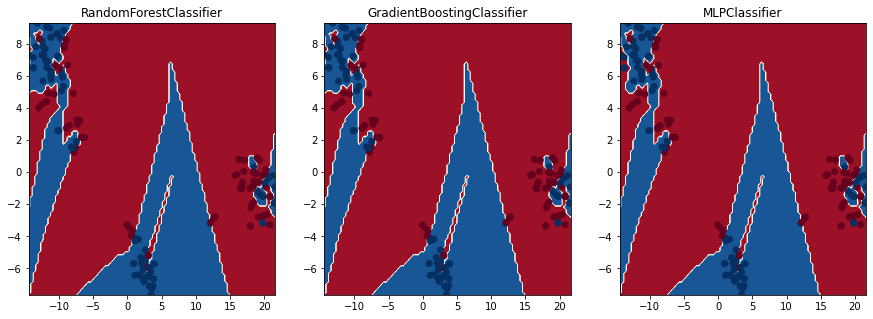

In [ ]:
plt.figure(figsize=(15, 5))
for i, model in enumerate(best_models):
  
  plt.subplot(int('13'+ str(i + 1)))
  model_name = type(model).__name__

  model.fit(X_train, y_train)

  y_pred = model.predict(X_val)

  # meshgrid
  resolution = 100
  Xmin, Xmax = np.min(X_val_2D[:,0]), np.max(X_val_2D[:,0])
  Ymin, Ymax = np.min(X_val_2D[:,1]), np.max(X_val_2D[:,1])
  xx, yy = np.meshgrid(np.linspace(Xmin, Xmax, resolution), np.linspace(Ymin, Ymax, resolution))

  # approximate Voronoi tesselation using 1-NN
  vornoi = KNeighborsClassifier(n_neighbors=1).fit(X_val_2D, y_pred) 
  voronoiBackground = vornoi.predict(np.c_[xx.ravel(), yy.ravel()])
  voronoiBackground = voronoiBackground.reshape((resolution, resolution))

  #plot
  plt.contourf(xx, yy, voronoiBackground, cmap = 'RdBu')
  plt.scatter(X_val_2D[:,0], X_val_2D[:,1], c=y_val, cmap = 'RdBu')
  plt.title(model_name)

plt.show()

## ROC and AUC <a class="anchor" id="roc"></a>

AUC for RandomForestClassifier = 1.0
AUC for GradientBoostingClassifier = 1.0
AUC for MLPClassifier = 0.9866816431322208


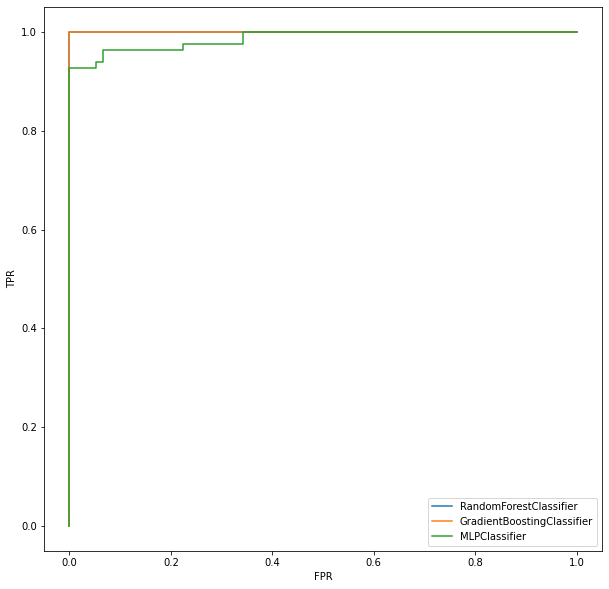

In [ ]:
plt.figure(figsize = (10, 10))

for model in best_models:
  model_name = type(model).__name__
  # NOTE: the models were already trained, so we just need to calculate their predictions
  prob_model = model.predict_proba(X_val)

  fpr, tpr, thresholds = roc_curve(y_val, prob_model[:,1])

  print("AUC for", model_name, '=', roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))

  plt.plot(fpr, tpr,label=model_name)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

## Confusion matrix <a class="anchor" id="confusionmatrix"></a>

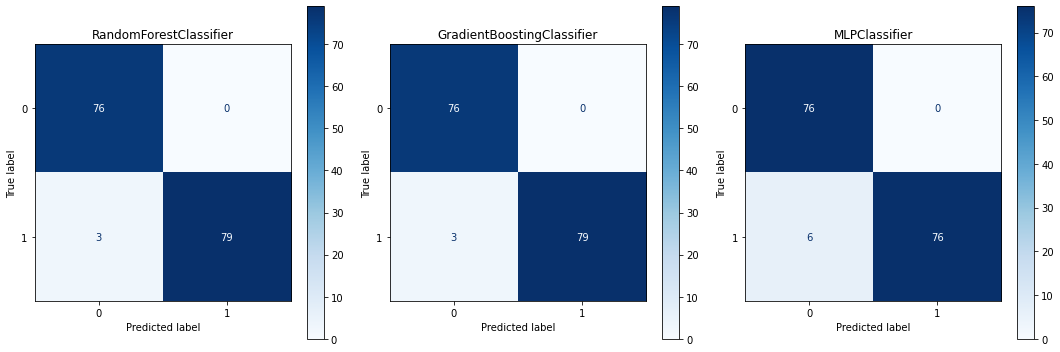

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))

for model, ax in zip(best_models, axes.flatten()):
  predictions = model.predict(X_val)
  cm = confusion_matrix(y_val, predictions, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot(ax = ax, cmap = 'Blues')
  ax.title.set_text(type(model).__name__)

plt.tight_layout()
plt.show()

# Predictions fot test data

In [ ]:
# best model
rf_clf = RandomForestClassifier(n_estimators = 150, max_features = 'sqrt', criterion = 'gini', max_depth = 9, random_state = 20)
gb_clf.fit(data_preprocessed, y)

y_pred = gb_clf.predict(data_test)

data_test['Disease'] = y_pred

In [ ]:
data_test

,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Exercise,Fruit_Habit,Birth_Year,Female,Checkup,Diabetes,Disease
PatientID,,,,,,,,,,,
1343,-0.666667,0.471698,0.379310,-0.866667,-1.0,-1.000000,0.041667,-1.0,0.232283,0.745455,1
1727,-0.566210,-0.320755,0.448276,-1.000000,-1.0,-1.000000,-0.125000,-1.0,0.232283,0.830357,1
1828,-0.511416,-0.320755,0.655172,-0.933333,1.0,-1.000000,0.375000,-1.0,0.762763,0.745455,1
1155,-0.164384,-0.735849,0.310345,-1.000000,-1.0,-1.000000,-0.041667,-1.0,0.232283,0.830357,1
1020,-0.730594,-0.132075,0.310345,-0.066667,-1.0,-1.000000,-0.291667,-1.0,0.762763,0.745455,0
...,...,...,...,...,...,...,...,...,...,...,...
1000,-0.607306,-0.415094,0.517241,-0.733333,-1.0,0.090909,0.041667,-1.0,0.232283,0.26129,0
1256,-0.739726,-0.169811,0.724138,-0.600000,-1.0,-1.000000,0.750000,1.0,0.762763,0.26129,1
1318,-0.767123,-0.132075,0.379310,-1.000000,1.0,-0.636364,-0.250000,-1.0,0.232283,0.26129,0


In [ ]:
data_test['Disease'].to_csv('/content/drive/MyDrive/Machine Learning/predictions.csv') # save predictions